In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_2009 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2009-2010')
df_2010 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')
df = pd.concat([df_2009, df_2010])

## 데이터 확인
- InvoiceNo: 주문번호
- StockCode: 제품코드
- Description: 제품설명
- Quantity: 주문수량
- InvoiceDate: 주문일
- UnitPrice: 제품단가
- CustomerID: 고객아이디
- Country: 국가

In [3]:
df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067371 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 73.3+ MB


In [5]:
#결측치 확인
df.isnull().sum() #고객ID가 누락된 행이 24만건

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [6]:
#데이터 기간 확인
print(min(df['InvoiceDate']), ' | ', max(df['InvoiceDate']))

2009-12-01 07:45:00  |  2011-12-09 12:50:00


In [7]:
#월별로 date 데이터 변환
df['InvoiceDate_month'] = df['InvoiceDate'].map(lambda date: date.strftime('%Y%m'))

In [8]:
#일별로 date 데이터 변환
df['InvoiceDate_date'] = df['InvoiceDate'].map(lambda date: date.strftime('%Y%m%d'))

# 유저 분석

# Monthly Active Users
* 10월, 11월에 활동 유저 수가 늘어나는 패턴이 보임.
* mau 값이 2010년 초 800명~ 1000명 안팎이다가 2010년 10월에 1600명대로 급증함. 같은 해 11월까지 증가.
* 다음해인 2011년에도 유사한 패턴을 보이며, 주로 연초와 여름 시기에 유저의 구매활동이 저조해 비수기로 볼 수 있음.

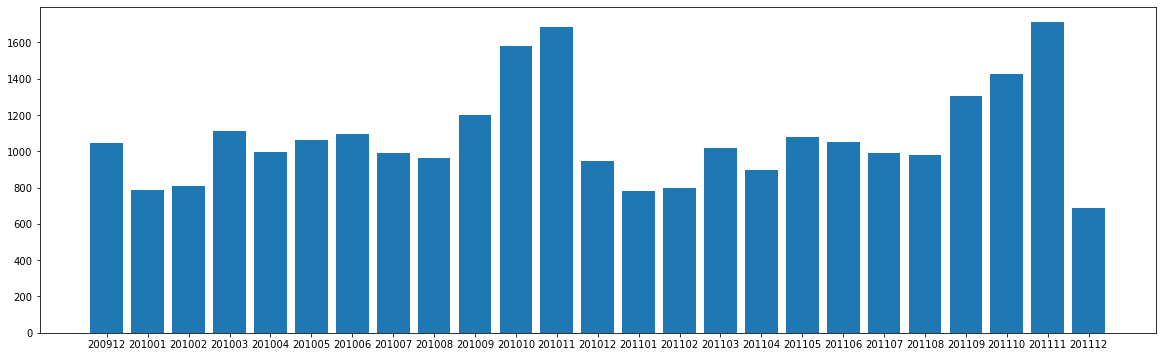

In [10]:
# MAU
mau = pd.DataFrame(df.groupby('InvoiceDate_month').nunique()['Customer ID'].reset_index())

plt.figure(figsize=(20,6))
plt.bar(mau['InvoiceDate_month'], mau['Customer ID'])
plt.show()

# Stickiness

* 연말인 11월과 12월에 고착도가 증가하는 경향이 있음. 4월, 5월에도 구매가 많아지면서 고착도가 증가함.
* 반면 2-3월과 여름/가을에는 고착도가 하락하는 패턴을 보임.

In [11]:
# DAU
dau = pd.DataFrame(df.groupby('InvoiceDate_date').nunique()['Customer ID'].reset_index())

# stickiness
dau['InvoiceDate_month'] = [x[:-2] for x in dau['InvoiceDate_date']]
dam = pd.merge(dau, mau, how='left', on='InvoiceDate_month')
dam['stickiness'] = dam['Customer ID_x'] / dam['Customer ID_y'] * 100

In [23]:
dam_re = pd.DataFrame(dam.groupby('InvoiceDate_month')['stickiness'].mean()).reset_index()

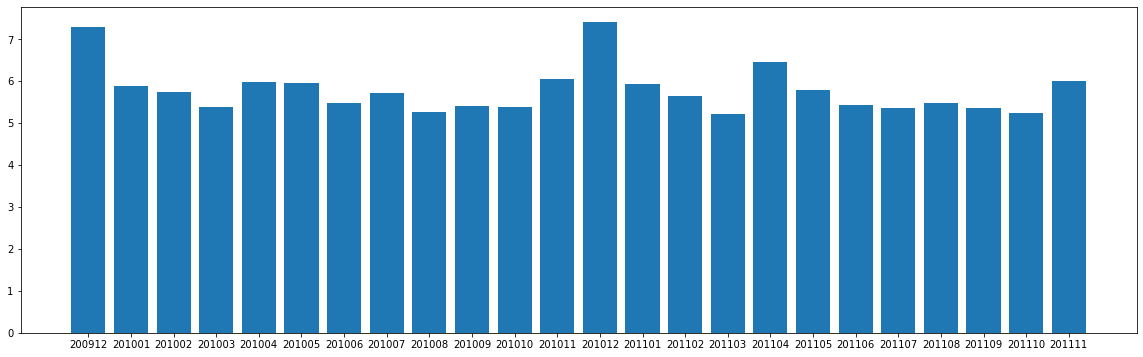

In [25]:
plt.figure(figsize=(20,6))
plt.bar(dam_re['InvoiceDate_month'][:-1], dam_re['stickiness'][:-1])
plt.show()

# 제품 판매 현황

## 주문 건수

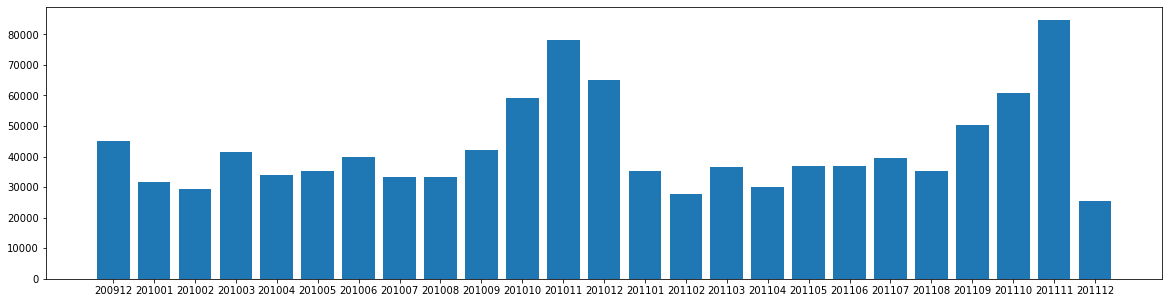

In [26]:
invoice = df.groupby('InvoiceDate_month').count()['Invoice'].reset_index()

plt.figure(figsize = (20, 5))
plt.bar(invoice['InvoiceDate_month'], invoice['Invoice'])
plt.show()

## 매출 분석

* 주문건수와 매출은 유사한 흐름을 보임. 역시 연말마다 구매 수량 및 매출이 급증하고, 2월과 4월에 가장 낮은 수치를 보임.

In [28]:
df['sales'] = df['Quantity'] * df['Price']
monthly_sales = df.groupby('InvoiceDate_month')['sales'].sum().reset_index()

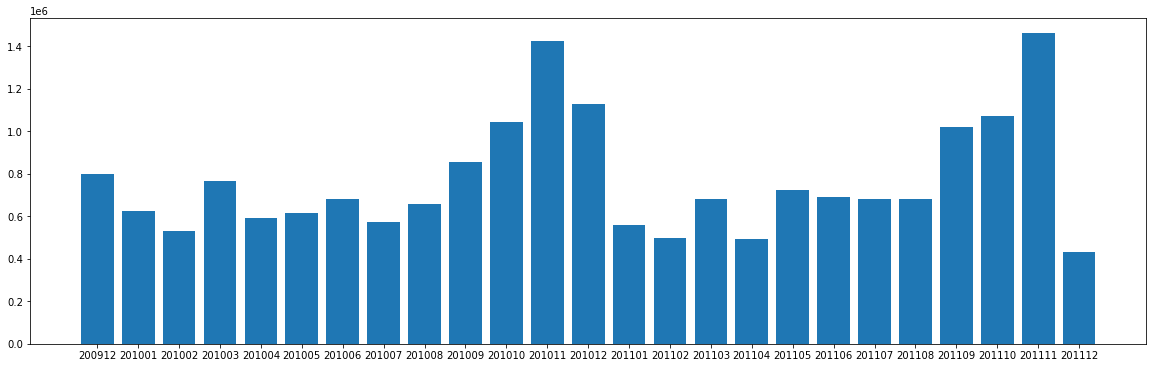

In [30]:
plt.figure(figsize=(20, 6))
plt.bar(monthly_sales['InvoiceDate_month'], monthly_sales['sales'])
plt.show()

## 주문 건단가
    
* 주문 건별 단가는 월별로 크게 차이 나지는 않으며, 매출과 주문이 가장 높은 연말에도 건단가는 평균치에 가까움.
* 주문 건단가가 가장 높은 것은 주로 매년 9월임.
* 2010년에 비해 2011년에는 5월과 6월의 건단가가 높게 나타났음.

In [31]:
monthly_sales_re = pd.merge(invoice, monthly_sales, on='InvoiceDate_month')
monthly_sales_re['sales_per_order'] = monthly_sales_re['sales'] / monthly_sales_re['Invoice']

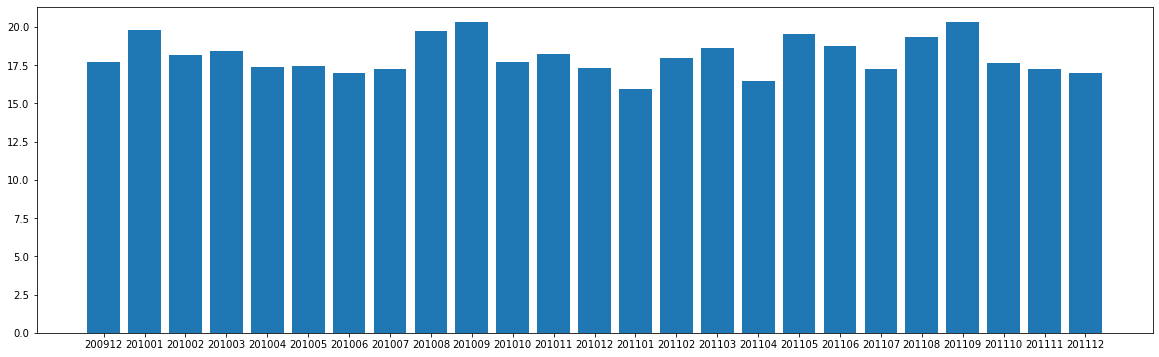

In [33]:
plt.figure(figsize=(20, 6))
plt.bar(monthly_sales_re['InvoiceDate_month'], monthly_sales_re['sales_per_order'])
plt.show()